<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/generative-models/samples/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import Optional, Tuple
from enum import Enum

import numpy as np

import torch
from torch import nn, Tensor
import torch.nn.functional as F

# Constants

In [ ]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# Utils

In [ ]:
def log_normal(x: Tensor, mu: Tensor, logvar: int) -> Tensor:
    dim = mu.shape[0]
    return (
        - 0.5 * dim * torch.log(2 * PI)
        - 0.5 * logvar
        - 0.5 * (x-mu)**2 * torch.exp(-logvar)
    )

In [ ]:
def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# VAE

## Encoder

In [ ]:
class EncodingType(str, Enum):
    encode = "encode"
    sample = "sample"

In [ ]:
class Encoder(nn.Module):
    def __init__(self, net: nn.Module):
        super(Encoder, self).__init__()
        self.net = net

    def forward(
        self,
        x: Optional[Tensor],
    ) -> Tuple[Tensor, Tensor]:
        mu, logvar = self.encode(x)
        out = self.reparametrize(mu, logvar)
        return out, self.log_prob(out, mu, logvar)

    def sample(self, mu_logvar: Tuple[Tensor, Tensor]):
        mu, logvar = mu_logvar
        x = self.reparametrize(mu, logvar)
        return x, self.log_prob(x, mu, logvar)

    @staticmethod
    def log_prob(x: Tensor, mu: Tensor, logvar: Tensor) -> Tensor:
        return log_normal(x, mu, logvar)

    def encode(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x = nn.Flatten()(x)
        x = self.net(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        return mu, log_var

    @staticmethod
    def reparametrize(mu: Tensor, logvar: Tensor) -> Tensor:
        sigma = torch.exp(0.5*logvar)
        eps = torch.rand_like(sigma)
        return mu + sigma * eps


## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, net: nn.Module, num_classes: int):
        super(Decoder, self).__init__()
        self.net = net
        self.num_classes = num_classes

    def forward(self, x: Tensor) -> Tensor:
        logits = self.net(x)
        logits = logits.view(
            logits.shape[0],  #batch_size
            -1,
            self.num_classes,
        )
        probs = torch.softmax(logits, -1)
        return probs

    def sample(self, x: Tensor) -> Tensor:
        probs = self.forward(x)
        sampled = torch.multinomial(
            input=probs.view(-1, self.num_classes),  # prob dist must be 1 or 2 dims
            num_samples=1
        ).view(probs.shape[0], probs.shape[1])
        return sampled

    def log_prob(self, x, mu):
        return log_categorical(
            x,
            mu,
            num_classes=self.num_classes,
            reduction ="sum",
            dim=-1,
        ).sum(-1)

In [ ]:
class Prior(nn.Module):
    def __init__(self, dim):
        super(Prior, self).__init__()
        self.dim = dim

    def sample(self, batch_size) -> Tensor:
        return torch.randn((batch_size, self.dim))

    def log_prob(self, x: Tensor):
        return log_normal(x, torch.zeros_like(x), torch.ones_like(x))

## VAE

In [ ]:
class ReductionType(str, Enum):
    mean = "mean"
    sum = "sum"

In [ ]:
class VAE(nn.Module):
    def __init__(
        self,
        encoder_net: nn.Module,
        decoder_net: nn.Module,
        prior: Prior,
        num_classes: int,
    ):
        super(VAE, self).__init__()
        self.encoder = Encoder(encoder_net)
        self.decoder = Decoder(decoder_net, num_classes)
        self.prior = prior

    def forward(self, x: Tensor, reduction: ReductionType = ReductionType.mean):
        z, log_prob_enc = self.encoder(x)
        decoded = self.decoder(z)
        rec_error = self.decoder.log_prob(x, decoded)
        kl = (
            self.prior.log_prob(z) - log_prob_enc
        ).sum(-1)
        elbo = - (rec_error + kl)
        if reduction == ReductionType.mean:
            out = elbo.mean()
        elif reduction == ReductionType.sum:
            out = elbo.sum()
        return out

    def sample(self, batch_size: int):
        z = self.prior.sample(batch_size)
        return self.decoder.sample(z)

## Test

In [ ]:
size_img = 64
size_z = 8
size_h = 16
num_classes = 17

In [ ]:
encoder_net = nn.Sequential(
    nn.Linear(size_img, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, 2*size_z),  # output concatenated mu and sigma
)

decoder_net = nn.Sequential(
    nn.Linear(size_z, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_img*num_classes),
)

In [ ]:
encoder = Encoder(encoder_net)

In [ ]:
prior = Prior(dim=size_z)

In [ ]:
img = torch.rand(size=(4, size_img))
img.shape

torch.Size([4, 64])

In [ ]:
z, log_prob = encoder(img)

In [ ]:
decoder = Decoder(decoder_net, num_classes)

In [ ]:
decoded = decoder(z)
print(decoded.shape)

torch.Size([4, 64, 17])


In [ ]:
vae = VAE(encoder_net, decoder_net, prior, num_classes)

In [ ]:
vae(img)

tensor(187.2825, grad_fn=<MeanBackward0>)

In [ ]:
vae.sample(2).shape

torch.Size([2, 64])

In [ ]:
vae.decoder.sample(vae.prior.sample(2)).shape

torch.Size([2, 64])

# Load Data

In [ ]:
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import PIL

In [ ]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [ ]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

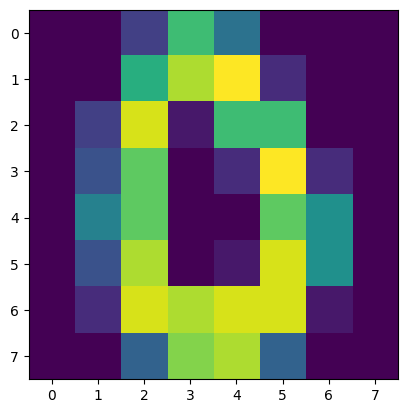

In [ ]:
idx = np.random.randint(len(train_data))
plt.imshow(train_data[idx].reshape(8, 8), interpolation='nearest')
plt.show()

# Train

In [ ]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss

In [ ]:
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.png', bbox_inches='tight')
    plt.close()

In [ ]:
def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.png', bbox_inches='tight')
    plt.close()

In [ ]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

In [ ]:
def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.png', bbox_inches='tight')
    plt.close()

## Run

In [ ]:
import os

In [ ]:
size_img = 64   # input dimension
size_h = 256  # the number of neurons in scale (s) and translation (t) nets
size_z = 16  # number of latents
num_classes = 17

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

In [ ]:
encoder_net = nn.Sequential(
    nn.Linear(size_img, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, 2*size_z),  # output concatenated mu and sigma
)

decoder_net = nn.Sequential(
    nn.Linear(size_z, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_h),
    nn.LeakyReLU(),
    nn.Linear(size_h, size_img*num_classes),
)

In [ ]:
model = VAE(
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    prior=Prior(dim=size_z),
    num_classes=num_classes,
)

In [ ]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

# Training procedure
nll_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

Epoch: 0, val nll=109.27550920758928
saved!
Epoch: 1, val nll=99.90139369419643
saved!
Epoch: 2, val nll=98.78867606026786
saved!
Epoch: 3, val nll=97.83171037946428
saved!
Epoch: 4, val nll=97.93759347098214
Epoch: 5, val nll=97.26201102120535
saved!
Epoch: 6, val nll=96.99905064174108
saved!
Epoch: 7, val nll=96.41723702566965
saved!
Epoch: 8, val nll=95.92390276227678
saved!
Epoch: 9, val nll=95.50353934151785
saved!
Epoch: 10, val nll=94.96653041294643
saved!
Epoch: 11, val nll=94.36927943638393
saved!
Epoch: 12, val nll=94.41122349330357
Epoch: 13, val nll=93.929443359375
saved!
Epoch: 14, val nll=93.7358203125
saved!
Epoch: 15, val nll=93.88160714285715
Epoch: 16, val nll=93.17721958705357
saved!
Epoch: 17, val nll=93.07366908482143
saved!
Epoch: 18, val nll=92.54508440290178
saved!
Epoch: 19, val nll=92.40188058035714
saved!
Epoch: 20, val nll=92.1022021484375
saved!
Epoch: 21, val nll=91.95657645089285
saved!
Epoch: 22, val nll=91.39445521763393
saved!
Epoch: 23, val nll=90.948

In [ ]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
with open(result_dir + name + '_test_loss.txt', "w") as fp:
    fp.write(str(test_loss))

FINAL LOSS: nll=82.78310262863535


In [ ]:
samples_real(result_dir + name, test_loader)

In [ ]:
plot_curve(result_dir + name, nll_val)

In [ ]:
%%bash

# rm  results/*
test -e vae_example.ipynb | wget https://raw.githubusercontent.com/jmtomczak/intro_dgm/main/vaes/vae_example.ipynb
test -e vae_example.py | jupyter nbconvert --to python vae_example.ipynb
pip install pytorch_model_summary
python vae_example.py

VAE by JT.
ENCODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]          16,640          16,640
       LeakyReLU-2            [1, 256]               0               0
          Linear-3            [1, 256]          65,792          65,792
       LeakyReLU-4            [1, 256]               0               0
          Linear-5             [1, 32]           8,224           8,224
Total params: 90,656
Trainable params: 90,656
Non-trainable params: 0
-----------------------------------------------------------------------

DECODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]           4,352           4,352
       LeakyReLU-2            [1, 256]               0               0
          Linear-3            [1, 256]     

--2023-12-20 14:01:38--  https://raw.githubusercontent.com/jmtomczak/intro_dgm/main/vaes/vae_example.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20756 (20K) [text/plain]
Saving to: ‘vae_example.ipynb’

     0K .......... ..........                                 100% 12.8M=0.002s

2023-12-20 14:01:39 (12.8 MB/s) - ‘vae_example.ipynb’ saved [20756/20756]

[NbConvertApp] Converting notebook vae_example.ipynb to python
[NbConvertApp] Writing 13956 bytes to vae_example.py
